## Project: FactoryGuard-AI
### Dataset: [NASA C-MAPSS-1 Turbofan Engine Degradation](https://www.kaggle.com/datasets/bishals098/nasa-turbofan-engine-degradation-simulation)
#### Week 2: Modeling and Imbalance Handling

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
train_df=pd.read_csv("/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/data/processed/processed_data.csv")
train_df

,engine_id,cycle,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_9_ema_12,sensor_11_ema_12,sensor_12_ema_12,sensor_13_ema_12,sensor_14_ema_12,sensor_15_ema_12,sensor_17_ema_12,sensor_20_ema_12,sensor_21_ema_12,label_24
0,1,12,642.06,1583.41,1400.15,554.52,2388.09,9049.37,47.18,521.80,...,9049.579221,47.211608,521.938474,2388.035130,8133.076871,8.408378,391.769252,38.992928,23.401434,0
1,1,13,643.07,1582.19,1400.83,553.44,2388.12,9046.82,47.38,521.85,...,9049.100115,47.240847,521.923112,2388.042921,8132.212697,8.409562,391.982957,38.982001,23.379602,0
2,1,14,642.35,1592.95,1399.16,554.48,2388.09,9047.37,47.44,521.67,...,9048.805532,47.274756,521.880015,2388.035613,8132.590233,8.407321,392.156127,39.015714,23.380112,0
3,1,15,642.43,1583.82,1402.13,553.64,2388.11,9052.22,47.30,522.50,...,9049.377514,47.278985,521.983873,2388.043048,8131.747583,8.409428,391.962456,39.011407,23.375068,0
4,1,16,642.13,1587.98,1404.50,553.94,2388.05,9049.34,47.24,521.49,...,9049.371314,47.272543,521.902257,2388.047502,8132.468507,8.406813,391.968660,39.004564,23.388277,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19526,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,...,9066.884787,48.085490,519.920653,2388.235148,8141.022486,8.510795,395.759712,38.441959,23.096156,1
19527,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,...,9066.611742,48.078491,519.883630,2388.232817,8140.326719,8.511273,395.642833,38.420119,23.105886,1
19528,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,...,9066.502244,48.080262,519.903071,2388.233922,8140.437993,8.519477,396.005474,38.423177,23.079334,1
19529,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,...,9067.612668,48.127914,519.867214,2388.233319,8140.261379,8.522465,395.850786,38.402689,23.076975,1


In [23]:
train_df["label_24"].value_counts()

label_24
0    17031
1     2500
Name: count, dtype: int64

In [24]:
train_df.drop(["engine_id","max_cycle","RUL"],axis="columns",inplace=True) # dropping since these columns directly reflect label_24

In [25]:
x=train_df.drop("label_24",axis="columns")
y=train_df['label_24']

### Base-Line model : Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Stratified split to preserve class imbalance ratio across train and test dataset

x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=32)

In [27]:
y_train.value_counts(),y_test.value_counts()

(label_24
 0    11921
 1     1750
 Name: count, dtype: int64,
 label_24
 0    5110
 1     750
 Name: count, dtype: int64)

Since the dataset is imbalanced and prediction of minority class is our business objective, We'll be focusing following metrics in this priority
- **Precision-Recall score (average_precision)** to focus on miniority desired class which represents failure
- **Recall** to capture early failure in engines
- **Precision** defines model's accuracy in correctly identifying failue engines

In [28]:
base_model=RandomForestClassifier(class_weight="balanced_subsample",random_state=32) # usage of class weight to mitigate imbalance
base_model.fit(x_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
from sklearn.metrics import average_precision_score,classification_report

y_base_pred_proba=base_model.predict_proba(x_test)[:,1]
y_base_pred=base_model.predict(x_test)

base_pr=average_precision_score(y_test,y_base_pred_proba)

print("AVG. PR Score: ",base_pr)
print("---")
print(classification_report(y_test,y_base_pred))

AVG. PR Score:  0.9682978729705296
---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5110
           1       0.93      0.84      0.88       750

    accuracy                           0.97      5860
   macro avg       0.95      0.92      0.93      5860
weighted avg       0.97      0.97      0.97      5860



### Production Model: LightGBM

In [30]:
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum() # computing class weight
scale_pos_weight

6.812

In [31]:
from lightgbm import LGBMClassifier

final_model=LGBMClassifier(scale_pos_weight=scale_pos_weight,random_state=32)

final_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1750, number of negative: 11921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24676
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128008 -> initscore=-1.918686
[LightGBM] [Info] Start training from score -1.918686


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
# Final model Metrics
y_final_pred=final_model.predict(x_test)
y_final_pred_proba=final_model.predict_proba(x_test)[:,1]

final_pr=average_precision_score(y_test,y_final_pred_proba)

print("Final PR score: ",final_pr)
print("---")
print(classification_report(y_test,y_final_pred))

Final PR score:  0.9853484624794266
---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5110
           1       0.94      0.94      0.94       750

    accuracy                           0.98      5860
   macro avg       0.97      0.97      0.97      5860
weighted avg       0.98      0.98      0.98      5860



In [47]:
final_pr>base_pr # This confirms the final model outperforms the baseline

True

### Evaluation of Final model

In [33]:
# StratifiedKFold to check if the model's predictions are stable across different subsets of data 
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=32)

pr_scores=[]

for train_idx,test_indx in skf.split(x,y):
    x_str_train,y_str_train=x.iloc[train_idx],y.iloc[train_idx]
    x_str_test,y_str_test=x.iloc[test_indx],y.iloc[test_indx]

    scale_pos_weight=(y_str_train==0).sum()/(y_str_train==1).sum()

    str_model=LGBMClassifier(scale_pos_weight=scale_pos_weight)
    str_model.fit(x_str_train,y_str_train)

    str_pred=str_model.predict_proba(x_str_test)[:,1]
    pr_s=average_precision_score(y_str_test,str_pred)
    pr_scores.append(pr_s)
    print(pr_s)

[LightGBM] [Info] Number of positive: 2000, number of negative: 13624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24696
[LightGBM] [Info] Number of data points in the train set: 15624, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128008 -> initscore=-1.918686
[LightGBM] [Info] Start training from score -1.918686
0.9885886987675069
[LightGBM] [Info] Number of positive: 2000, number of negative: 13625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24703
[LightGBM] [Info] Number of data points in the train set: 15625, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128000 -> initscore=-1.918759
[LightGBM] [Info] Start training from score -

In [34]:
import numpy as np
print(pr_scores)
print("Mean PR Scores",np.mean(pr_scores))
print("Final Model PR: ",final_pr)

[0.9885886987675069, 0.9914654088262116, 0.9884638102001828, 0.98668525750236, 0.9913723857839776]
Mean PR Scores 0.9893151122160477
Final Model PR:  0.9853484624794266


**Final model's PR Score is approximately equal to the mean PR Score computed from K-Fold indicating less variance and stable performance of the model**

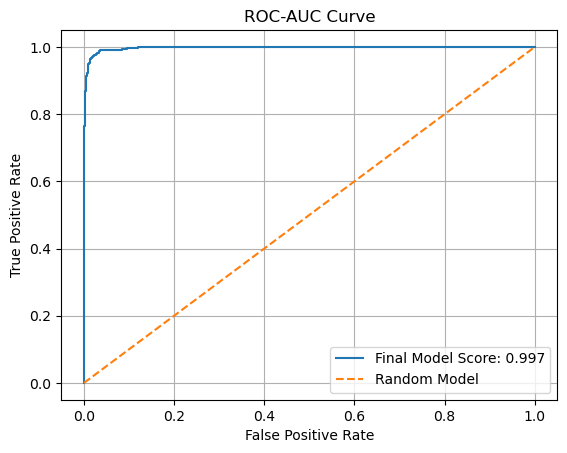

In [43]:
from sklearn.metrics import roc_curve,f1_score,fbeta_score,precision_score,recall_score,roc_auc_score

fpr,tpr,threshold=roc_curve(y_test,y_final_pred_proba)

plt.plot(fpr,tpr,label=f"Final Model Score: {round(roc_auc_score(y_test,y_final_pred_proba),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],label="Random Model",linestyle="--")
plt.title("ROC-AUC Curve")
plt.grid(True)
plt.legend()
plt.show()

/home/abhi/miniforge3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


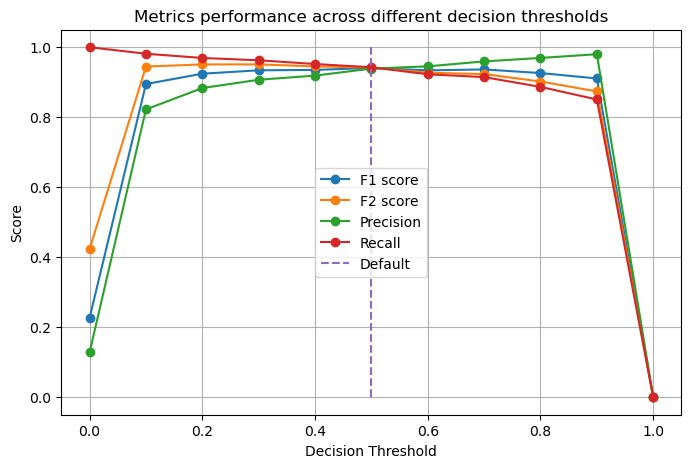

In [44]:
f1=[]
f2=[]
pre=[]
re=[]
lim=[]

for thresh in np.arange(0.0,1.1,0.1):
    y_thresh=(y_final_pred_proba>=thresh).astype(int)
    f1.append(f1_score(y_test,y_thresh))
    f2.append(fbeta_score(y_test,y_thresh,beta=2))
    pre.append(precision_score(y_test,y_thresh))
    re.append(recall_score(y_test,y_thresh))
    lim.append(thresh)

plt.figure(figsize=(8,5))
plt.plot(lim, f1, marker="o", label="F1 score")
plt.plot(lim, f2, marker="o", label="F2 score")
plt.plot(lim, pre, marker="o", label="Precision")
plt.plot(lim, re, marker="o", label="Recall")
plt.plot([0.5,0.5],[0,1],label="Default",linestyle="--")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Metrics performance across different decision thresholds")
plt.legend()
plt.grid(True)

plt.show()

**Default Threshold is selected for optimal performance across all metrics**

In [51]:
print("Final Model Summary")
print("PR score: ",final_pr)
print("---")
print(classification_report(y_test,y_final_pred))
print("---")
print("ROC AUC Score: ",roc_auc_score(y_test,y_final_pred))

Final Model Summary
PR score:  0.9853484624794266
---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5110
           1       0.94      0.94      0.94       750

    accuracy                           0.98      5860
   macro avg       0.97      0.97      0.97      5860
weighted avg       0.98      0.98      0.98      5860

---
ROC AUC Score:  0.9668323548597522


In [52]:
x.columns.to_list()

['cycle',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_20',
 'sensor_21',
 'sensor_2_lag_1',
 'sensor_2_lag_2',
 'sensor_3_lag_1',
 'sensor_3_lag_2',
 'sensor_4_lag_1',
 'sensor_4_lag_2',
 'sensor_7_lag_1',
 'sensor_7_lag_2',
 'sensor_8_lag_1',
 'sensor_8_lag_2',
 'sensor_9_lag_1',
 'sensor_9_lag_2',
 'sensor_11_lag_1',
 'sensor_11_lag_2',
 'sensor_12_lag_1',
 'sensor_12_lag_2',
 'sensor_13_lag_1',
 'sensor_13_lag_2',
 'sensor_14_lag_1',
 'sensor_14_lag_2',
 'sensor_15_lag_1',
 'sensor_15_lag_2',
 'sensor_17_lag_1',
 'sensor_17_lag_2',
 'sensor_20_lag_1',
 'sensor_20_lag_2',
 'sensor_21_lag_1',
 'sensor_21_lag_2',
 'sensor_2_mean_1',
 'sensor_3_mean_1',
 'sensor_4_mean_1',
 'sensor_7_mean_1',
 'sensor_8_mean_1',
 'sensor_9_mean_1',
 'sensor_11_mean_1',
 'sensor_12_mean_1',
 'sensor_13_mean_1',
 'sensor_14_mean_1',
 'sensor_15_mean_1',
 'sensor_17_mean_1',
 'sens

In [16]:
import os
import joblib

output_dir = "/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/output"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(x.columns.to_list(), os.path.join(output_dir, "features.pkl"))
joblib.dump(final_model, os.path.join(output_dir, "final_model.pkl"))

['/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/output/final_model.pkl']